In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.impute import SimpleImputer

# Initialize DataFrame
hist_df = pd.DataFrame(columns=['Date'])

# Specify ticker symbols
symbols = ['AAPL','AMZN','DIA','FB','MSFT','NFLX','SPY','TSLA','TWTR','XOM']

# Initialize mean imputer for replacing NaN vales
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

for s in symbols:
    
    # Read-in DataFrame
    sym_df = pd.read_csv(s+'.csv')
    
    # Fit imputer on DataFrame of each symbol
    imp_mean.fit(sym_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])
    
    # Impute DataFrame of each symbol
    imp_df = pd.DataFrame(imp_mean.transform(sym_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]))
    
    # Rename DataFrame to original columns
    imp_df.rename(columns={0:'Open', 1:'High', 2:'Low',3:'Close', 4:'Adj Close', 5:'Volume'}, inplace=True)
    
    # Convert Date column from "object" to "datetime"
    imp_df['Date'] = pd.to_datetime(sym_df.Date)
    
    # Create ticker symbol column
    imp_df['Symbol'] = s
    
    # Create columns specifying number of days since IPO
    imp_df['Num_Days'] = (imp_df['Date'] - imp_df['Date'].min()).dt.days
    
    # Append to overall DataFrame containing all data
    hist_df = hist_df.append(imp_df,sort=False)

hist_df

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Num_Days
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.404953,117258400.0,AAPL,0.0
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.383825,43971200.0,AAPL,3.0
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.355655,26432000.0,AAPL,4.0
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.364458,21610400.0,AAPL,5.0
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.375022,18362400.0,AAPL,6.0
...,...,...,...,...,...,...,...,...,...
12607,2020-08-06,43.400002,43.900002,43.250000,43.639999,42.795731,14434900.0,XOM,18256.0
12608,2020-08-07,43.230000,43.520000,42.810001,43.439999,42.599598,18749700.0,XOM,18257.0
12609,2020-08-10,43.990002,44.599998,43.599998,44.509998,43.648899,24367800.0,XOM,18260.0
12610,2020-08-11,45.500000,46.419998,44.730000,44.970001,44.100002,28987500.0,XOM,18261.0


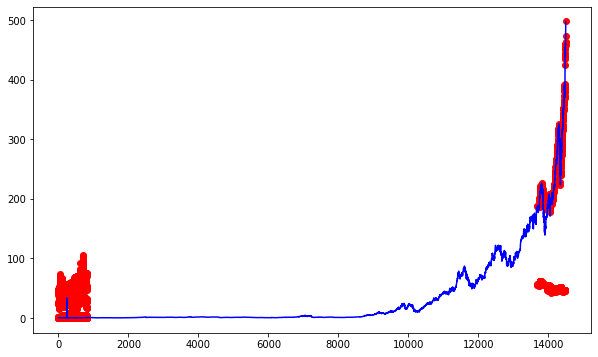

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# def detect_anomaly(ticker):

# Specify input data
data = hist_df[hist_df.Symbol == 'AAPL'][['Num_Days','Adj Close']]

# Initialize StandardScaler
scaler = StandardScaler()

# Use StandardScaler to fit and transform imputed data
np_scaled = scaler.fit_transform(data)

# Return scaled data
data = pd.DataFrame(np_scaled)

# train oneclassSVM
outliers_fraction = 0.1
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)
hist_df['anomaly'] = pd.Series(model.predict(data)) # add SVM results to DataFrame
a = hist_df.loc[hist_df['anomaly'] == -1, ['Num_Days', 'Adj Close']] # Select anomaly data only

# Plot original Adj Close Prices and detected anomalies
plt.figure(figsize=(10,6))
plt.plot(hist_df[hist_df.Symbol == 'AAPL']['Num_Days'], hist_df[hist_df.Symbol == 'AAPL']['Adj Close'], color='blue')
plt.scatter(a['Num_Days'],a['Adj Close'], color='red')
plt.show();
    
# for s in symbols:
#     detect_anomaly(s)